# Create and run a local RAG pipeline from scratch

## What is RAG?

RAG stands for Retrieval Augmented Generation.

The goal of RAG is to take information and pass it to an LLM so it can generate outputs based on that information.

* Retrieval - Find relevant information given a query, e.g. "what are the macronutrients and what do they do?" -> retrieves passages of text related to the macronutrients from a nutrition textbook.
* Augmented - We want to take the relevant information and augment our input (prompt) to an LLM with that relevant information.
* Generation - Take the first two steps and pass them to an LLM for generative outputs.

If you want to read where RAG came from, see the paper from Facebook AI: https://arxiv.org/abs/2005.11401

> This work offers several positive societal benefits over previous work: the fact that it is more
strongly grounded in real factual knowledge (in this case Wikipedia) makes it “hallucinate” less
with generations that are more factual, and offers more control and interpretability. RAG could be
employed in a wide variety of scenarios with direct benefit to society, for example by endowing it
with a medical index and asking it open-domain questions on that topic, or by helping people be more
effective at their jobs. 

## Why RAG?

The main goal of RAG is to improve the generation outputs of LLMs.

1. Prevent hallucinations - LLMs are incredibly good at generating good *looking* text, however, this text doesn't mean that it's factual. RAG can help LLMs generate information based on relevant passages that are factual.
2. Work with custom data - Many base LLMs are trained with internet-scale data. This means they have a fairly good understanding of language in general. However, it also does a lot of their responses can be generic in nature. RAG helps to create specific responses based on specific documents (e.g. your own companies customer support documents). 

## What can RAG be used for?

* Customer support Q&A chat - Treat your existing customer support documents as a resource and when a customer asks a question, you could have a retrieval system, retrieve relevant documentation snippets and then have an LLM craft those snippets into an answer. Think of this as a "chatbot for your documentation".
* Email chain analysis - Let's say you're a large insurance company and you have chains and chains of emails of customer claims. You could use a RAG pipeline to find relevant information from those emails and then use an LLM to process that information into structured data.
* Company internal documentation chat
* Textbook Q&A - Let's say you're a nutrition student and you've got a 1200 page textbook read, you could build a RAG pipeline to go through the textbook and find relevant passages to the questions you have.

Common theme here: take your relevant documents to a query and process them with an LLM.

From this angle, you can consider an LLM as a calculator for words.

## Why local?

Fun.

Privacy, speed, cost.

* Privacy - If you have private documentation, maybe you don't want to send that to an API. You want to setup an LLM and run it on your own hardware.
* Speed - Whenever you use an API, you have to send some kind of data across the internet. This takes time. Running locally means we don't have to wait for transfers of data.
* Cost - If you own your hardware, the cost is paid. It may have a large cost to begin with. But overtime, you don't have to keep paying API fees.
* No vendor lockin - If you run your own software/hardware. If OpenAI/another large internet company shut down tomorrow, you can still run your business.


## What we're going to build

* https://github.com/mrdbourke/simple-local-rag
* https://whimsical.com/simple-local-rag-workflow-39kToR3yNf7E8kY4sS2tjV

We're going to build NutriChat to "chat with a nutrition textbook". 

Specifically:

1. Open a PDF document (you could use almost any PDF here or even a collection of PDFs).
2. Format the text of the PDF textbook ready for an embedding model.
3. Embed all of the chunks of text in the textbook and turn them into numerical reprentations (embedding) which can store for later.
4. Build a retrieval system that uses vector search to find relevant chunk of text based on a query.
5. Create a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to a query based on the passages of the textbook with an LLM.

All locally!

1. Steps 1-3: Document preprocessing and embedding creation.
2. Steps 4-6: Search and answer.

## 1. Document/text processing and embedding creation

Ingredients: 
* PDF document of choice (note: this could be almost any kind of document, I've just chosen to focus on PDFs for now).
* Embedding model of choice.

Steps:
1. Import PDF document.
2. Process text for embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later (embeddings will store on file for many years or until you lose your hard drive).

### Import PDF Document

In [1]:
import os
import requests

# Get PDF document path
pdf_path = "../Babok_Guide_V3_pdf.pdf"

# Download PDF
if not os.path.exists(pdf_path):
    print("[INFO] File doesn't exist, downloading...")

    # Enter the URL of the PDF
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    # The local filename to save the downloaded file
    filename = pdf_path

    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Open the file and save it
        with open(filename, "wb") as file:
            file.write(response.content) 
        print(f"[INFO] The file has been download and saved as {filename}")
    else:
        print(f"[INFO] Failed to download the file. Status code: {reponse.status_code}")

else:
    print(f"File {pdf_path} exists.")

File ../Babok_Guide_V3_pdf.pdf exists.


We've got a PDF, let's open it!

In [2]:
import fitz # requires: !pip install PyMuPDF, see: https://github.com/pymupdf/PyMuPDF 
from tqdm.auto import tqdm # pip install tqdm

def text_formatter(text: str) -> str: 
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()

    # Potentially more text formatting functions can go here
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = [] 
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number": page_number - 12,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_setence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4, # 1 token = ~4 characters
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -12,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_setence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -11,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_setence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [3]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 1089,
  'page_char_count': 1403,
  'page_word_count': 292,
  'page_setence_count_raw': 1,
  'page_token_count': 350.75,
  'text': 'Macrobiotic  Diet  • Low in saturated fats  and high in fiber  • Emphasizes whole  foods and  de-emphasizes  processed foods  • Rich in phytoestrogens,  which may reduce the  risk of estrogen-related  cancers  • Not entirely  evidence-based  • Lacks certain  vitamins and  minerals;  supplements are  often required  • Can result in a very  low caloric intake  • Lack of energy may  result from  inadequate protein  Mediterranean  Diet  • A reduced risk of  cardiovascular disease  and mortality  • A lower risk of cancer  • De-emphasizes  processed foods and  emphasizes whole  foods and healthy fats  • Lower sodium intake,  due to fewer processed  foods  • Emphasis on  monosaturated fats  leads to lower  cholesterol  • Highlighting fruits and  vegetables raises  consumption of  antioxidants  • Does not specify  daily serving  amounts  • Potentia

In [4]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_setence_count_raw,page_token_count,text
0,-12,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-11,0,1,1,0.00,
2,-10,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-9,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-8,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [5]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_setence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,591.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-12.00,0.00,1.00,1.00,0.00
25%,289.75,762.00,134.00,5.00,190.50
50%,591.50,1231.50,216.00,10.00,307.88
75%,893.25,1603.50,272.00,15.00,400.88
max,1195.00,2308.00,430.00,39.00,577.00


Why would we care about token count? 

Token count is important to think about because:
1. Embedding models don't deal with infinite tokens.
2. LLMs don't deal with infinite tokens.

For example an embedding model may have been trained to embed sequences of 384 tokens into numerical space (sentence-transformers `all-mpnet-base-v2`, see: https://www.sbert.net/docs/pretrained_models.html). 

As for LLMs, they can't accept infinite tokens in their context window, plus it would be cost ineffective to send 100,000s of tokens to an LLM every time.

We want the tokens we send to an LLM to valuable tokens.

### Further text processing (splitting pages into sentences)

Two ways to do this:
1. We've done this by splitting on `". "`.
2. We can do this with a NLP library such as spaCy (https://spacy.io/usage) and nltk (https://www.nltk.org/).

In [6]:
from spacy.lang.en import English

# Create instance of English language class
nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer 
nlp.add_pipe("sentencizer")

# Create document instance as an example
doc = nlp("This is a sentence. This another sentence. I like elephants.")
assert len(list(doc.sents)) == 3

# Print out our sentences split
list(doc.sents)

[This is a sentence., This another sentence., I like elephants.]

In [7]:
pages_and_texts[300]

{'page_number': 288,
 'page_char_count': 622,
 'page_word_count': 105,
 'page_setence_count_raw': 4,
 'page_token_count': 155.5,
 'text': 'Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.    An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=187    An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=187  The Functions of Carbohydrates in the Body  |  259'}

In [8]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings (the default type is a spaCy datatype)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [9]:
random.sample(pages_and_texts, k=1)

[{'page_number': 504,
  'page_char_count': 1405,
  'page_word_count': 250,
  'page_setence_count_raw': 13,
  'page_token_count': 351.25,
  'text': '• Patronize local farms and fruit-and-vegetable stands.  • Talk to your grocer and ask for better whole-food choices and  seafood at a decent price.  • Ask the restaurants you frequently go to, to serve more  nutritious food and to accurately display calories of menu  items.  National Level  • Support policies that increase the walkability of cities.  • Support national campaigns addressing obesity, such as  America on the Move.  • Support policies that support local farmers and the increased  access and affordability of healthy food.  Some scientists predict that the childhood obesity rate will reach  100 percent by 2044. It is critical for the nation’s health to change  our environment to one that promotes weight loss and/or weight  maintenance. However, action is needed on multiple fronts to  reverse the obesity epidemic trend within one

In [10]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_setence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,591.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-12.00,0.00,1.00,1.00,0.00,0.00
25%,289.75,762.00,134.00,5.00,190.50,5.00
50%,591.50,1231.50,216.00,10.00,307.88,10.00
75%,893.25,1603.50,272.00,15.00,400.88,15.00
max,1195.00,2308.00,430.00,39.00,577.00,28.00


### Chunking our sentences together

The concept of splitting larger pieces of text into smaller ones is often referred to as text splitting or chunking.

There is no 100% correct way to do this.

We'll keep it simple and split into groups of 10 sentences (however, you could also try 5, 7, 8, whatever you like).

There are frameworks such as LangChain which can help with this, however, we'll stick with Python for now: https://python.langchain.com/docs/modules/data_connection/document_transformers/ 

Why we do this:
1. So our texts are easier to filter (smaller groups of text can be easier to inspect that large passages of text).
2. So our text chunks can fit into our embedding model context window (e.g. 384 tokens as a limit).
3. So our contexts passed to an LLM can be more specific and focused.

In [11]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function to split lists of texts recursively into chunk size
# e.g. [20] -> [10, 10] or [25] -> [10, 10, 5]
def split_list(input_list: list[str],
               slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [12]:
# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [13]:
random.sample(pages_and_texts, k=1)

[{'page_number': -1,
  'page_char_count': 988,
  'page_word_count': 179,
  'page_setence_count_raw': 1,
  'page_token_count': 247.0,
  'text': 'Defining Protein  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  363  The Role of Proteins in Foods: Cooking and  Denaturation  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  374  Protein Digestion and Absorption  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  378  Protein’s Functions in the Body  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  383  Diseases Involving Proteins  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  395  Proteins in a Nutshell  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  405  Proteins, Di

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_setence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,591.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-12.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,289.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,591.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,893.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1195.00,2308.00,430.00,39.00,577.00,28.00,3.00


### Splitting each chunk into its own item 

We'd like to embed each chunk of sentences into its own numerical representation.

That'll give us a good level of granularity.

Meaning, we can dive specifically into the text sample that was used in our model.

In [15]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts): 
    for sentence_chunk in item["sentence_chunks"]: 
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka join the list of sentences into one paragraph
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" => ". A" (will work for any captial letter)

        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get some stats on our chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 chars

        pages_and_chunks.append(chunk_dict) 

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [16]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 472,
  'sentence_chunk': 'Effects of Alcohol Abuse on the Brain A small amount (up to 10%) of the liver acetaldehyde may accumulate inside the liver cells. As more alcohol is ingested, this stimulates the production of acetaldehyde by both the alcohol dehydrogenase and MEOS systems. As the levels of acetaldehyde increase inside the liver cells with heavy consumption of alcohol, some of the acetaldehyde diffuse into the blood circulation. In circulation, high levels of acetaldehyde cause nausea and vomiting. Vomiting causes more body dehydration and loss of electrolytes. If the dehydration becomes severe enough, this can impair brain function and a person may lose consciousness. Alcohol can adversely affect nearly every area of the brain. When BAC rises, the central nervous system is depressed. Alcohol disrupts the way nerve cells communicate with each other by interfering with receptors on certain cells. The immediate impact of alcohol on the brain can be seen in the a

In [17]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,612.38,734.10,112.74,183.52
std,347.79,447.51,71.24,111.88
min,-12.00,12.00,3.00,3.00
25%,309.50,315.00,45.00,78.75
50%,615.00,745.00,115.00,186.25
75%,919.00,1118.00,173.00,279.50
max,1195.00,1830.00,297.00,457.50


In [18]:
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-12,Human Nutrition: 2020 Edition,29,4,7.25
1,-10,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00
2,-9,Human Nutrition: 2020 Edition by University of...,210,30,52.50
3,-8,Contents Preface University of Hawai‘i at Māno...,766,116,191.50
4,-7,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25


### Filter chunks of text for short chunks

These chunks may not contain much useful information.

In [19]:
# Show random chunks with under 25 tokens in length
min_token_length = 25
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 20.5 | Text: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=84  The Digestive System | 81
Chunk token count: 12.75 | Text: PART VIII CHAPTER 8. ENERGY Chapter 8. Energy | 451
Chunk token count: 24.5 | Text: view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=354 Phytochemicals | 605
Chunk token count: 20.25 | Text: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=118  132 | The Immune System
Chunk token count: 11.25 | Text: Carbohydrates and Personal Diet Choices | 275


In [20]:
# Filter our DataFrame for rows with under 25 tokens
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -10,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -9,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [21]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 269,
  'sentence_chunk': 'But mechanical breakdown is ongoing—the strong peristaltic contractions of the stomach mix the carbohydrates into the more uniform mixture of chyme. Figure 4.6 Salivary Glands in the Mouth 240 | Digestion and Absorption of Carbohydrates',
  'chunk_char_count': 236,
  'chunk_word_count': 35,
  'chunk_token_count': 59.0}]

### Embedding our text chunks

Embeddings are a broad but powerful concept.

While humans understand text, machines understand numbers.

What we'd like to do:
- Turn our text chunks into numbers, specifically embeddings.

A useful numerical representation.

The best part about embeddings is that are a *learned* representation.

```
{"the": 0,
"a": 1,
...
```

For a great resource on learning embeddings, see here: https://vickiboykis.com/what_are_embeddings/ 

In [22]:
import torch

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"   # Apple Silicon GPU
else:
    device = "cpu"

from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="sentence-transformers/all-mpnet-base-v2",
                                      device=device)

# Create a list of sentences
sentences = ["The Sentence Transformer library provides an easy way to create embeddings.",
             "Sentences can be embedded one by one or in a list.",
             "I like horses!"]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")

/Users/yiukitcheung/Desktop/local-rag/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/yiukitcheung/Desktop/local-rag/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The Sentence Transformer library provides an easy way to create embeddings.
Embedding: [-3.44285928e-02  2.95329466e-02 -2.33643483e-02  5.57257310e-02
 -2.19097976e-02 -6.47060201e-03  1.02849826e-02 -6.57804310e-02
  2.29717437e-02 -2.61120368e-02  3.80421318e-02  5.61402477e-02
 -3.68747078e-02  1.52788833e-02  4.37021144e-02 -5.19723184e-02
  4.89479266e-02  3.58107197e-03 -1.29750976e-02  3.54387611e-03
  4.23261933e-02  3.52606475e-02  2.49401573e-02  2.99177468e-02
 -1.99381709e-02 -2.39752997e-02 -3.33373551e-03 -4.30449583e-02
  5.72013929e-02 -1.32517582e-02 -3.54478322e-02 -1.13935824e-02
  5.55561930e-02  3.61099211e-03  8.88527211e-07  1.14027346e-02
 -3.82229984e-02 -2.43550492e-03  1.51313487e-02 -1.32596062e-04
  5.00659049e-02 -5.50877117e-02  1.73444971e-02  5.00958860e-02
 -3.75959948e-02 -1.04463743e-02  5.08322418e-02  1.24860490e-02
  8.67376700e-02  4.64143865e-02 -2.10689958e-02 -3.90251167e-02
  1.99692999e-03 -1.42345764e-02 -1.86795350e-02  2.826694

In [23]:
embeddings[0].shape

(768,)

In [24]:
embedding = embedding_model.encode("My favourite animal is the cow!")
embedding

array([-1.45473368e-02,  7.66727254e-02, -2.85872370e-02, -3.31283398e-02,
        3.65210660e-02,  4.78570722e-02, -7.08107427e-02,  1.62834134e-02,
        1.93444267e-02, -2.80482061e-02, -2.91747209e-02,  5.11309654e-02,
       -3.28720249e-02, -8.98753572e-03, -1.03672594e-02, -3.15488093e-02,
        4.22784016e-02, -9.13283136e-03, -1.94017179e-02,  4.35689315e-02,
       -2.31997520e-02,  4.29883003e-02, -1.72393341e-02, -2.01372672e-02,
       -3.13574038e-02,  8.08165316e-03, -2.06725113e-02, -2.27869637e-02,
        2.44812518e-02,  1.71968509e-02, -6.26672879e-02, -7.54797161e-02,
        3.57422270e-02, -5.46574453e-03,  1.24730320e-06, -7.63202179e-03,
       -3.53222005e-02,  1.91326886e-02,  3.99045572e-02,  2.11728527e-03,
        1.64565444e-02,  9.84049961e-03, -1.80700496e-02,  9.33832303e-03,
        3.23482864e-02,  5.84786013e-02,  4.23187502e-02,  1.62090808e-02,
       -9.14911553e-02,  1.82305519e-02, -5.25729498e-03, -7.81018101e-03,
       -3.47644165e-02, -

In [25]:
%%time

# embedding_model.to("cpu")

# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1712 [00:00<?, ?it/s]

CPU times: user 27.4 s, sys: 6 s, total: 33.4 s
Wall time: 1min 13s


In [26]:
%%time

embedding_model.to("mps")

for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1712 [00:00<?, ?it/s]

CPU times: user 22.6 s, sys: 5.46 s, total: 28 s
Wall time: 1min 8s


In [27]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

CPU times: user 138 μs, sys: 574 μs, total: 712 μs
Wall time: 714 μs


'Carbohydrates and Personal Diet Choices UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM In this chapter, you learned what carbohydrates are, the different types of carbohydrates in your diet, and that excess consumption of some types of carbohydrates cause disease while others decrease disease risk. Now that we know the benefits of eating the right carbohydrate, we will examine exactly how much should be eaten to promote health and prevent disease. How Many Carbohydrates Does a Person Need? The Food and Nutrition Board of IOM has set the Recommended Dietary Allowance (RDA) of carbohydrates for children and adults at 130 grams per day. This is the average minimum amount the brain requires to function properly. The Acceptable Macronutrient Distribution Range (AMDR) for carbohydrates is between 45 and 65 percent of your total caloric daily intake. This means that on a 2,000 kilocalorie diet, a person should consume between 225 and 325 g

In [28]:
len(text_chunks)

1712

In [29]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can experiment to find which batch size leads to best results
                                               convert_to_tensor=True)
text_chunk_embeddings                        

CPU times: user 2.88 s, sys: 1.32 s, total: 4.2 s
Wall time: 44.6 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='mps:0')

### Save embeddings to file



In [30]:
pages_and_chunks_over_min_token_len[419]

{'page_number': 300,
 'sentence_chunk': 'Carbohydrates and Personal Diet Choices UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM In this chapter, you learned what carbohydrates are, the different types of carbohydrates in your diet, and that excess consumption of some types of carbohydrates cause disease while others decrease disease risk. Now that we know the benefits of eating the right carbohydrate, we will examine exactly how much should be eaten to promote health and prevent disease. How Many Carbohydrates Does a Person Need? The Food and Nutrition Board of IOM has set the Recommended Dietary Allowance (RDA) of carbohydrates for children and adults at 130 grams per day. This is the average minimum amount the brain requires to function properly. The Acceptable Macronutrient Distribution Range (AMDR) for carbohydrates is between 45 and 65 percent of your total caloric daily intake. This means that on a 2,000 kilocalorie diet, a per

In [31]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [32]:
# Import saved file and view 
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-10,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242526e-02 9.02282372e-02 -5.09549258e-...
1,-9,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139736e-02 -1.66167244e-...
2,-8,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 2.79801674e-02 3.39814313e-02 -2.06426512e-...
3,-7,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 6.82566836e-02 3.81275043e-02 -8.46853852e-...
4,-6,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264308e-02 -8.49765819e-03 9.57158115e-...


If your embedding database is really large (e.g. over 100k-1M samples) you might want to look into using a vector database for storage: https://en.wikipedia.org/wiki/Vector_database

## 2. RAG - Search and Answer

RAG goal: Retrieve relevant passages based on a query and use those passages to augment an input to an LLM so it can generate an output based on those relevant passages.

### Similarity search

Embeddings can be used for almost any type of data.

For example, you can turn images into embeddings, sound into embeddings, text into embeddings, etc...

Comparing embeddings is known as similarity search, vector search, semantic search.

In our case, we want to query our nutrition textbook passages based on semantics or *vibe*.

So if I search for "macronutrients functions" I should get relevant passages to that text but may not contain exactly the words "macronutrient functions".

Whereas with keyword search, if I search "apple" I get back passages with specifically "apple". 


In [33]:
import random

import torch
import numpy as np
import pandas as pd

device = "mps" if torch.backends.mps.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert our embeddings into a torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embedding_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device)

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

text_chunks_and_embedding_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-10,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242526, 0.0902282372, -0.00509549258, -..."
1,-9,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139736, -0.0166167244, -0..."
2,-8,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,"[0.0279801674, 0.0339814313, -0.0206426512, 0...."
3,-7,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,"[0.0682566836, 0.0381275043, -0.00846853852, -..."
4,-6,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264308, -0.00849765819, 0.00957158115, ..."
...,...,...,...,...,...,...
1707,1193,Flashcard Images Note: Most images in the flas...,1304,186,326.00,"[0.0185622573, -0.0164277349, -0.0127045736, -..."
1708,1193,Hazard Analysis Critical Control Points reused...,374,51,93.50,"[0.0334721319, -0.0570440255, 0.015148947, -0...."
1709,1194,ShareAlike 11. Organs reused “Pancreas Organ A...,1285,175,321.25,"[0.0770516098, 0.00978556368, -0.0121817356, 0..."
1710,1194,Sucrose reused “Figure 03 02 05” by OpenStax B...,410,63,102.50,"[0.103045121, -0.0164702218, 0.00826847646, 0...."


In [34]:
embeddings.shape

torch.Size([1712, 768])

In [35]:
# Create model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(
    model_name_or_path="all-mpnet-base-v2",
    device=device
    )

/Users/yiukitcheung/Desktop/local-rag/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embedding model ready!

Let's create a small semantic search pipeline.

In essence, we want to search for a query (e.g. "macronutrient functions") and get back relevant passages from our textbook.

We can do so with the following steps:
1. Define a query string.
2. Turn the query string into an embedding.
3. Perform a dot product or cosine similarity function between the text embeddings and the query embedding.
4. Sort the results from 3 in descending order.

In [36]:
embeddings.shape

torch.Size([1712, 768])

Note: to use dot product for comparison, ensure vector sizes are of same shape (e.g. 768) and tensors/vectors are in the same datatype (e.g. both are in torch.float32).

In [37]:
# 1. Define the query
query = "busienss case study"
print(f"Query: {query}")
 
# 2. Embed the query
# Note: it's import to embed you query with the same model you embedding your passages
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("mps")

# 3. Get similarity scores with the dot product (use cosine similarity if outputs of model aren't normalized)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer() 

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep top 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product 

Query: busienss case study
[INFO] Time taken to get scores on 1712 embeddings: 0.01424 seconds.


torch.return_types.topk(
values=tensor([0.2625, 0.2620, 0.2582, 0.2433, 0.2380], device='mps:0'),
indices=tensor([ 710, 1509, 1476,   36, 1667], device='mps:0'))

In [38]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer() 

print(f"[INFO] Time taken to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([171200, 768])
[INFO] Time taken to get scores on 171200 embeddings: 0.01446 seconds.


We can see that searching over embeddings is very fast even if we do exhaustive.

But if you had 10M+ embeddings, you likely want to create an index.

An index is like letters in the dictionary.

For example, if you wanted to search "duck" in the dictionary, you'd start at "d" then find words close to "du..." etc.

An index helps to narrow it down.

A populary indexing library for vector search is Faiss, see here: https://github.com/facebookresearch/faiss 

One technique that the library provides is approximate nearest neighbour search (ANN): https://en.wikipedia.org/wiki/Nearest_neighbor_search

Let's make our vector search results pretty. 

In [39]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [40]:
query = "Business Case Study"
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'Business Case Study'

Results:
Score: 0.2625
Text:
to conduct work are a chair and a computer. The list of all the societal
obesogenic factors goes on and on. They are the result of modernization,
industrialization, and urbanization continuing on without individuals, public
health officials, or government adequately addressing the concurrent rise in
overweight and obesity. With obesity at epidemic proportions in America it is
paramount that policies be implemented or reinforced at all levels of society,
and include education, agriculture, industry, urban planning, healthcare, and
government. Reversing and stopping obesity are two different things. The former
will require much more societal and individual change than the latter. The
following are some ideas for constructing an environment in America that
promotes health and confronts the obesity epidemic: Individual Level • Purchase
less prepared foods and eat more whole foods. • Decrease portion sizes when
eating or serving foo

Note: We could potentially improve the order of these results with a reranking model. A model that has been trained specifically to take search results (e.g. the top 25 semantic results) and rank them in order from most likely top-1 to least likely.

See here for an open-source reranking model: https://huggingface.co/mixedbread-ai/mxbai-rerank-large-v1

To check our results, what if we wanted to automatically surface the page of texts related to our query?

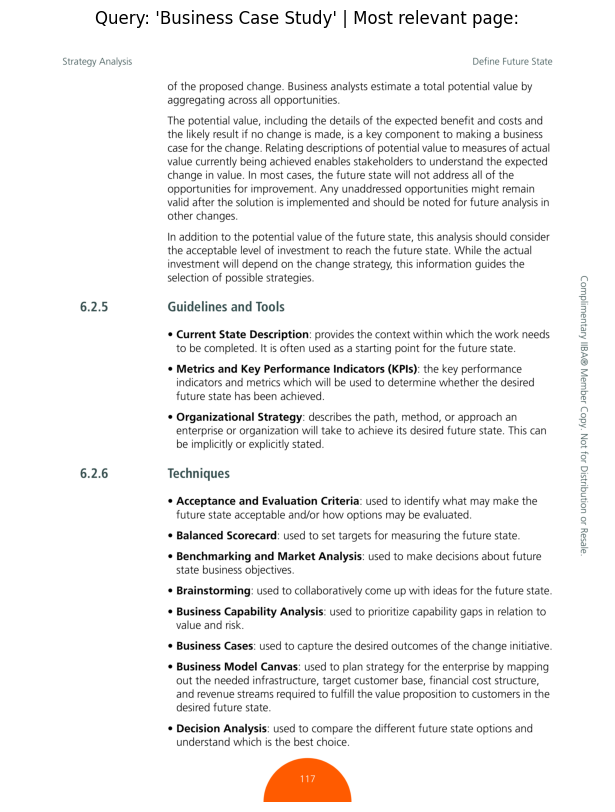

In [41]:
import fitz # pymupdf library

# open PDF and load target
pdf_path = "Babok_Guide_V3_pdf.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(114 + 12) # note: page numbers of our PDF start 41+

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Save image (optional)
# img.save("output_filename.png")
doc.close()

# Convert the pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis("off")
plt.show()

### Similarity measures: dot product and cosine similarity

Two of the most common similarity measures between vectors are dot product and cosine similarity.

In essence, closer vectors will have higher scores, further away vectors will have lower scores.

Vectors have direction (which way is it going?) and magnitude (how long is it?).

In [42]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example vectors/tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))


Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


### Functionizing our semantic search pipeline

Let's put all of the steps from above for semantic search into a functionor two so we can repeat the workflow.

In [43]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on ({len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Finds relevant passages given a query and prints them out along with their scores.
    """
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    # Loop through zipped together scores and indices from torch.topk
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")

In [ ]:
query="foods high in fiber"
# retrieve_relevant_resources(query=query, embeddings=embeddings) 
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on (1680 embeddings: 0.00005 seconds.
Score: 0.6964
Text:
• Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
Page number: 276


Score: 0.6810
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a
few dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados. Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure. Soluble fibers are more easily accessible to
bacterial enzymes in the large intestine so they can be broken down to a greater
extent tha

: 

### Getting an LLM for local generation 

We want to focus on local genertion.

However, this process will also work with an LLM API.

What is a generative LLM?

Goes from text input -> generate text output.

Which LLM should I use?

* How much hardware VRAM do you have available?

### Checking our local GPU memory availability

In [ ]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 24 GB


: 

Notes: 
* to use `gemma-7b-it` or other Gemma models, you have to accept terms & conditions on Hugging Face: https://huggingface.co/google/gemma-7b-it 
* to download models and run locally from Hugging Face, you may need to sign in to the Hugging Face CLI: https://huggingface.co/docs/huggingface_hub/en/guides/cli

In [ ]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 24 | Recommend model: Gemma 7B in 4-bit or float16 precision.
use_quantization_config set to: False
model_id set to: google/gemma-7b-it


: 

### Loading an LLM locally

We can load an LLM locally using Hugging Face `transformers`.

The model I'm going to use on my NVIDIA RTX 4090 - https://huggingface.co/google/gemma-7b-it 

To get a model running local we're going to need a few things:
1. A quantization config (optional) - a config on what precision to load the model in (e.g. 8bit, 4bit, etc)
2. A model ID - this will tell transformers which model/tokenizer to load
3. A tokenizer - this turns text into numbers ready for the LLM (note: a tokenizer is different from an embedding model)
4. An LLM model - this will be what we use to generate text based on an input!

> **Note:** There are many tips and tricks on loading/making LLMs work faster. One of the best ones is flash_attn (Flash Attention 2). See the GitHub for more: https://github.com/Dao-AILab/flash-attention 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create a quantization config
# Note: requires !pip install bitsandbytes accelerate
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: flash attention 2 = faster attention mechanism
# Flash Attention 2 requires a GPU with a compute capability score of 8.0+ (Ampere, Ada Lovelace, Hopper and above): https://developer.nvidia.com/cuda-gpus 
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa" # scaled dot product attention
print(f"Using attention implementation: {attn_implementation}") 

# 2. Pick a model we'd like to use
# model_id = "google/gemma-7b-it"
model_id = model_id

# 3. Instantiate tokenizer (tokenizer turns text into tokens)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model 
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use as much memory as we can
                                                 attn_implementation=attn_implementation)

if not use_quantization_config:
    llm_model.to("cuda")

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

: 

In [ ]:
print(f"Using attention implementation: {attn_implementation}") 

Using attention implementation: flash_attention_2


: 

In [ ]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaFlashAttention2(
          (q_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (v_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3072, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (up_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (down_proj): Linear(in_features=24576, out_features=3072, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): Gem

: 

In [ ]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

8537680896

: 

In [ ]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3) 

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2), 
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 17142470656,
 'model_mem_mb': 16348.33,
 'model_mem_gb': 15.97}

: 

We got the size our model.

This means to load Gemma 7b-it in float16 we need a minimum of 16GB of VRAM, however due to the calculations that take place in the forward pass, we actually need closer to 19GB.

### Generating text with our LLM

Let's generate text with our local LLM!

* Note: Some models have been trained/tuned to generate text with a specific template in mind.

Because `gemma-7b-it` has been trained in an instruction-tuned manner, we should follow the instruction template for the best results.

In [ ]:
input_text = "What are the macronutrients and what are their functions in the body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients and what are their functions in the body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients and what are their functions in the body?<end_of_turn>
<start_of_turn>model



: 

In [ ]:
tokenizer

GemmaTokenizerFast(name_or_path='google/gemma-7b-it', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	106: AddedToken("<start_of_turn>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	107: AddedToken("<end_of_turn>", rstrip=False, lstr

: 

In [ ]:
%%time

# Tokenize the input text (turn it into numbers) and send it to the GPU
input_ids = tokenizer(prompt,
                      return_tensors="pt").to("cuda")

# Generate outputs from local LLM
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256)
print(f"Model output (tokens):\n{outputs[0]}\n")

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592,    578,   1212,    708,   1024,   7257,    575,    573,   2971,
        235336,    107,    108,    106,   2516,    108,  21404, 235269,   1517,
           708,    573, 186809, 184592,    578,   1024,   7257,    575,    573,
          2971, 235292,    109,    688, 235274, 235265, 110165,  56227,  66058,
           109, 235290,   5231,   8086,  66058,    108,    139, 235290,  34428,
          4134,    604,    573,   2971, 235265,    108,    139, 235290,  13332,
         41748,   5330,   9347,   5902, 235265,    108,    139, 235290,  34428,
         20149,    604,  51536,    578,  69583,   8069, 235265,    108,    139,
        235290,  13332,   2500, 155248,    604,   7387, 235265,    109,    688,
        235284, 235265,  96084,  66058,    109, 235290,   5231,   8086,  66058,
           108,    139, 235290,   8108,    578,  12158,  29703, 235265,    108,
           139, 2

: 

In [ ]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients and what are their functions in the body?<end_of_turn>
<start_of_turn>model
Sure, here are the macronutrients and their functions in the body:

**1. Carbohydrates:**

- **Function:**
  - Provide energy for the body.
  - Help regulate blood sugar levels.
  - Provide fiber for digestion and bowel movement.
  - Help build glycogen for storage.

**2. Proteins:**

- **Function:**
  - Build and repair tissues.
  - Make enzymes and other chemicals.
  - Help regulate blood sugar levels.
  - Help build muscle mass and strength.

**3. Fats:**

- **Function:**
  - Provide energy storage.
  - Help absorb vitamins and minerals.
  - Help regulate blood sugar levels.
  - Help build cell membranes.<eos>



: 

In [ ]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions
query_list

['What are the macronutrients, and what roles do they play in the human body?',
 'How do vitamins and minerals differ in their roles and importance for health?',
 'Describe the process of digestion and absorption of nutrients in the human body.',
 'What role does fibre play in digestion? Name five fibre containing foods.',
 'Explain the concept of energy balance and its importance in weight management.',
 'How often should infants be breastfed?',
 'What are symptoms of pellagra?',
 'How does saliva help with digestion?',
 'What is the RDI for protein per day?',
 'water soluble vitamins']

: 

In [ ]:
import random

query = random.choice(query_list)
print(f"Query: {query}") 

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: What are the macronutrients, and what roles do they play in the human body?
[INFO] Time taken to get scores on (1680 embeddings: 0.00005 seconds.


(tensor([0.7302, 0.7233, 0.6962, 0.6942, 0.6416], device='cuda:0'),
 tensor([42, 47, 46, 41, 52], device='cuda:0'))

: 

### Augmenting our prompt with context items 

We've done retrieval.

We've done generation.

Time to augment!

The concept of augmenting a prompt with context items is also referred as prompt engineering.

Prompt engineering is an active field of research and many new styles and techniques are being found out.

However, there are a fair few techniques that work quite well.

Resources:
* https://www.promptingguide.ai/
* https://github.com/brexhq/prompt-engineering
* https://www.anthropic.com/news/prompt-engineering-for-business-performance 

We're going to use a couple of prompting technqiues:
1. Give clear instructions.
2. Give a few examples of input/output (e.g. given this input, I'd like this output).
3. Give room to think (e.g. create a scratchpad/"show your working space"/"let's think step by step...".

Let's create a function to format a prompt with context items.

In [ ]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:""" 
    base_prompt = base_prompt.format(context=context,
                                     query=query)

    # Create prompt template for instruction-tuned model 
    dialogue_template = [
        {"role": "user",
         "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                           tokenize=False,
                                           add_generation_prompt=True)
    
    return prompt

query = random.choice(query_list) 
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format our prompt
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: Explain the concept of energy balance and its importance in weight management.
[INFO] Time taken to get scores on (1680 embeddings: 0.00005 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vita

: 

Prompt example:

```
Based on the following contexts:
- sdjfhasdfjh
- dfhsdlfj
- sdfsdakfjaslkjf
- iwqewiurbndf
- dsfsd;fadskjfh

Please answer the following query: What are the macronutrients and what do they do?
Answer:
```

In [ ]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # from 0 to 1 and the lower the value, the more deterministic the text, the higher the value, the more creative
                             do_sample=True, # whether or not to use sampling, https://huyenchip.com/2024/01/16/sampling.html
                             max_new_tokens=256)

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")
print(f"RAG answer:\m{output_text.replace(prompt, '')}")

Query: Explain the concept of energy balance and its importance in weight management.
RAG answer:\m<bos>Sure, here is the answer to the query:

Energy balance plays a key role in weight management. It is the state in which the energy intake is equal to the energy expended by the body. When you are in a positive energy balance, the excess nutrient energy will be stored or used to grow. When you are in a negative energy balance, your body will need to use its stores to provide energy. Weight can be thought of as a whole body estimate of energy balance.

Therefore, maintaining energy balance is essential for maintaining a stable body weight. When you are in energy balance, your weight remains stable. When you are in a negative energy balance, you will lose weight. And when you are in a positive energy balance, you will gain weight.<eos>
CPU times: total: 3.48 s
Wall time: 8.06 s


: 

### Functionize our LLM answering feature

Wouldn't it be cool if our RAG pipeline worked from a single function? 

E.g. you input a query and you get a generated answer + optionally also get the source documents (the context) where that answer was generated from.

Let's make a function to do it!

In [ ]:
def ask(query: str,
        temperature: float=0.7,
        max_new_tokens:int=256,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # RETRIEVAL
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices] 

    # Add score to context item
    for i, item in enumerate(context_items): 
        item["score"] = scores[i].cpu()

    # AUGMENTATION
    # Create the prompt and format it with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # GENERATION
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Decode the tokens into text
    output_text = tokenizer.decode(outputs[0])

    # Format the answer
    if format_answer_text:
        # Replace prompt and special tokens
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "")

    # Only return the answer without context items
    if return_answer_only:
        return output_text

    return output_text, context_items

: 

In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")
ask(query=query,
    temperature=0.2,
    return_answer_only=False)

Query: What is the RDI for protein per day?
[INFO] Time taken to get scores on (1680 embeddings: 0.00005 seconds.


('**Relevant passages:**\n\n- "The RDA, therefore, is the amount of protein a person should consume in their diet to balance the amount of protein used up and lost from the body."\n- "The recommended daily allowance (RDA) for protein was determined to be 0.8 grams of protein per kilogram of body weight."\n- "The AMDR is the calculated range of how much energy from carbohydrates, fats, and protein is recommended for a healthy diet adequate of the essential nutrients and is associated with a reduced risk of chronic disease."\n\n**Answer:**\n\nThe RDI (Recommended Daily Allowance) for protein per day is 0.8 grams of protein per kilogram of body weight. This amount is determined by assessing nitrogen balance, which is the balance between the amount of protein used up and lost from the body.',
 [{'page_number': 410,
   'sentence_chunk': 'Most nitrogen is lost as urea in the urine, but urea is also excreted in the feces. Proteins are also lost in sweat and as hair and nails grow. The RDA, th

: 

## Summary

* RAG = powerful technique for generating text based on reference documents.
* Doesn't have to be too complicated to setup. We've just built one from scratch running on our local machines that can run in 3-4 functions.
* Hardware use = use GPU where possible to accelerate embedding creation and LLM generation.
    * Keep in mind the limitations on your local hardware.
* Many open-source embedding models and LLMs starting to became available, keep experimenting to find which is best.
* Semantic search is a really helpful tool.

: 